# Notebook #5: Series temporales: predicción a futuro de la población

In [28]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_funciones_BBDD as sfbd
from src import soporte_sarima as ss
from src import soporte_temporales as st
from src import soporte_variables_poblacion as svp

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
df_poblacion = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svp.query_poblacion)

In [32]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [33]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329201,2478189,3268336,5146997,7373664,9485026,11331265


In [34]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [35]:
analisis_st.graficar_serie()

## Análisis de la serie temporal del parque vehicular

- Se puede observar una tendencia en ascenso, lo que indica que ha tenido un crecimiento uniforme en el transcurso del tiempo. Sin embargo, entre el 1990-2000 esta línea que muestra un ascenso casi lineal empieza a mostrar un cambio en su fuerza de aumento. Lo cuál queda más claro a partir del 2010.

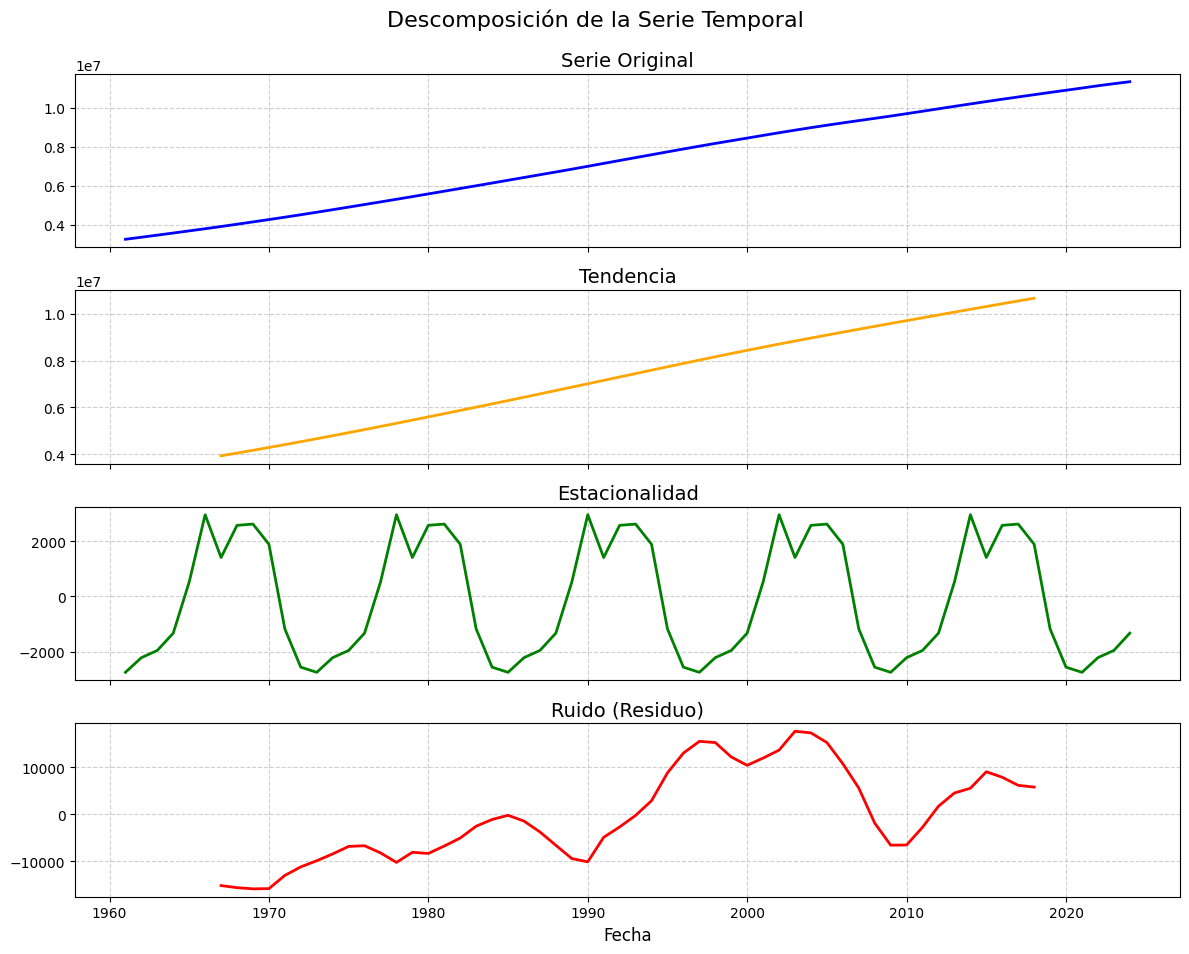

In [36]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

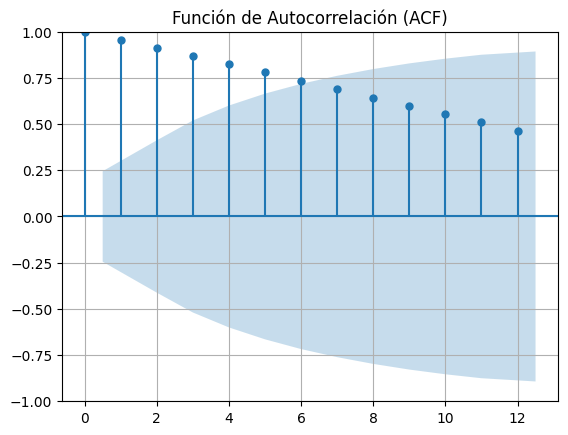

<Figure size 1200x1000 with 0 Axes>

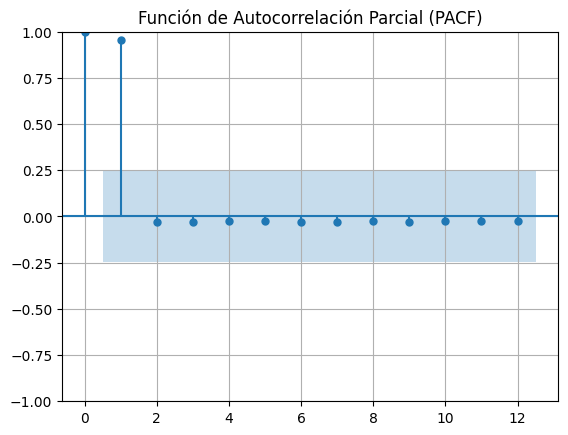

In [37]:
analisis_st.graficar_acf_pacf(lags=12)

## Análisis de las gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta, lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Hasta el lag número 6 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del sexto lag, las correlaciones se adentran al intervalo de confianza.

3. **Estacionalidad**:
   - No tiene estacionalidad ya que son datos anuales   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa, indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - El segundo lag también tiene una fuerte conexión, sin embargo pasado este todos caen dentro del intervalo de confianza. De manera que los lags más lejanos no tienen influencia directa significativa.
---

In [38]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.7268586635941947
p-value: 0.0037508380967098305
Valores Críticos:
1%: -3.548493559596539
5%: -2.912836594776334
10%: -2.594129155766944
Rechazamos la hipótesis nula. La serie es estacionaria.


## Prophet

In [39]:
df_poblacion.columns = ['ds', 'y']

In [40]:
df_poblacion.set_index('ds', inplace=True)

### Cálculo de baseline

In [41]:
df_poblacion['prev'] = df_poblacion['y'].shift(1)
df_poblacion['ape'] = (df_poblacion['prev'] - df_poblacion['y']).abs() / df_poblacion['y'].astype(float)

In [42]:
train_size = int(0.7 * len(df_poblacion))
y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [43]:
y_test['ape'].mean()

0.011556774208749083

    - El MAPE ofrecido por como baseline es de 1.1%. Esto viene de tomar como referencia para la predicción del siguiente año, al año actual.

In [44]:
df_poblacion.drop(columns=['prev', 'ape'], inplace=True)
y_train.drop(columns=['prev', 'ape'], inplace=True)
y_test.drop(columns=['prev', 'ape'], inplace=True)

In [45]:
df_poblacion.reset_index(inplace=True)

In [46]:
m = Prophet()
m.fit(df_poblacion)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

16:37:19 - cmdstanpy - INFO - Chain [1] start processing
16:37:22 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1960-12-31,200337,3260010,3273945,200337,200337,3066690,3066690,3066690,3066690,3066690,3066690,0,0,0,3267027
1,1961-12-31,308191,3366772,3380421,308191,308191,3065559,3065559,3065559,3065559,3065559,3065559,0,0,0,3373750
2,1962-12-31,416046,3473369,3487442,416046,416046,3064376,3064376,3064376,3064376,3064376,3064376,0,0,0,3480422
3,1963-12-31,523900,3580939,3594687,523900,523900,3063875,3063875,3063875,3063875,3063875,3063875,0,0,0,3587775
4,1964-12-31,632050,3692387,3705920,632050,632050,3066690,3066690,3066690,3066690,3066690,3066690,0,0,0,3698740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2021-12-31,8057709,11116036,11129809,8057709,8057709,3065559,3065559,3065559,3065559,3065559,3065559,0,0,0,11123268
62,2022-12-31,8174407,11231359,11245658,8174407,8174407,3064376,3064376,3064376,3064376,3064376,3064376,0,0,0,11238784
63,2023-12-31,8291106,11348049,11361638,8291106,8291106,3063875,3063875,3063875,3063875,3063875,3063875,0,0,0,11354982
64,2024-12-31,8408125,11466834,11482442,8406788,8409441,3066690,3066690,3066690,3066690,3066690,3066690,0,0,0,11474815


In [47]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
61,2021-12-31,11123268,11115575,11130135
62,2022-12-31,11238784,11231678,11246013
63,2023-12-31,11354982,11347809,11362072
64,2024-12-31,11474815,11467784,11481536
65,2025-12-31,11590382,11581252,11599542


In [48]:
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df['poblacion'] = df_poblacion['y']
df = df[df['poblacion'].notnull() & df['yhat'].notnull()]
df.tail(5)

,ds,yhat,yhat_lower,yhat_upper,poblacion
59,2019-12-31,10887867,10880979,10894384,10894043
60,2020-12-31,11007700,11000996,11014419,11008300
61,2021-12-31,11123268,11115575,11130135,11123476
62,2022-12-31,11238784,11231678,11246013,11230734
63,2023-12-31,11354982,11347809,11362072,11331265


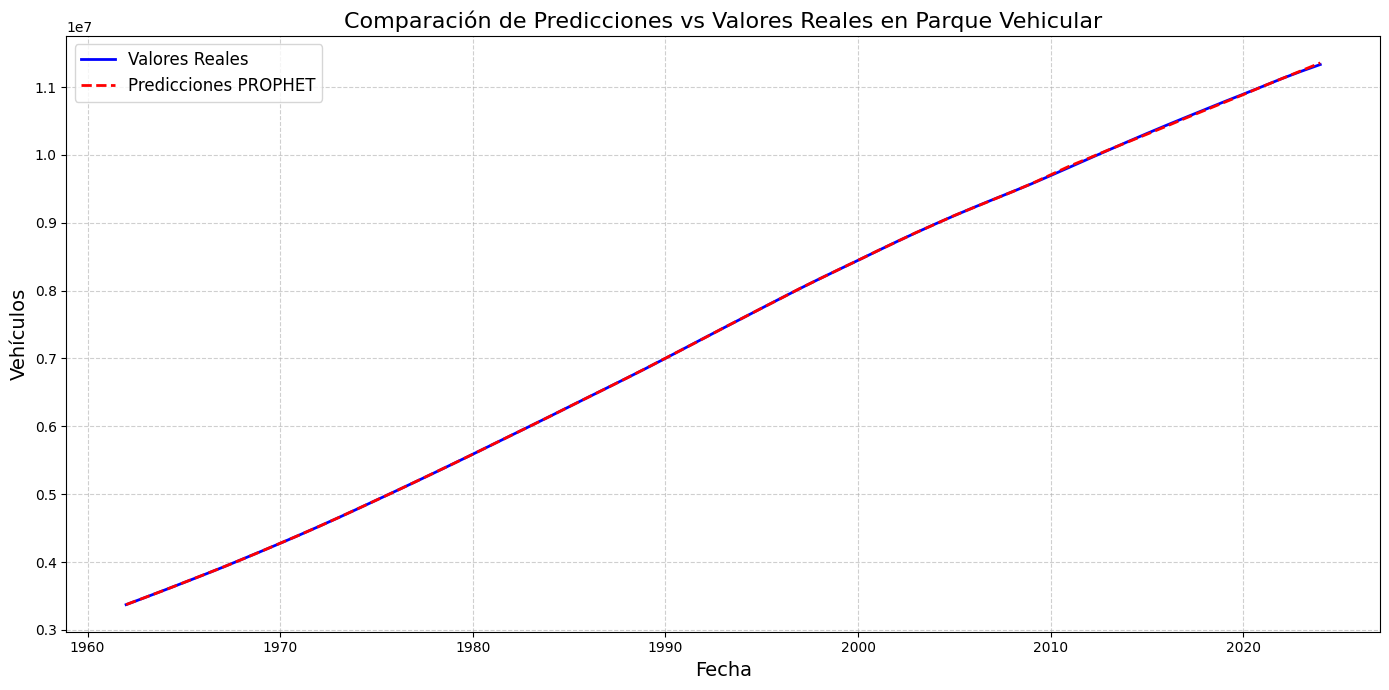

In [49]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df[1:], x="ds", y="poblacion", label="Valores Reales", color="blue", linewidth=2) # valores reales
sns.lineplot(data=df[1:], x="ds", y="yhat", label="Predicciones PROPHET", color="red", linestyle="--", linewidth=2) # predicciones
plt.title("Comparación de Predicciones vs Valores Reales en Parque Vehicular", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Vehículos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6) # formato cuadriculado
plt.tight_layout()
plt.show()

In [50]:
# Seleccionar las columnas relevantes
y_real = df['poblacion']
y_pred = df['yhat']

# Cálculo de MAE
mae = mean_absolute_error(y_real, y_pred)
mape = mean_absolute_percentage_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# Imprimir los resultados
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")               
print(f"RMSE: {rmse}")

MAE: 2831.8361744950307
MAPE: 0.03%
RMSE: 5435.27222720849


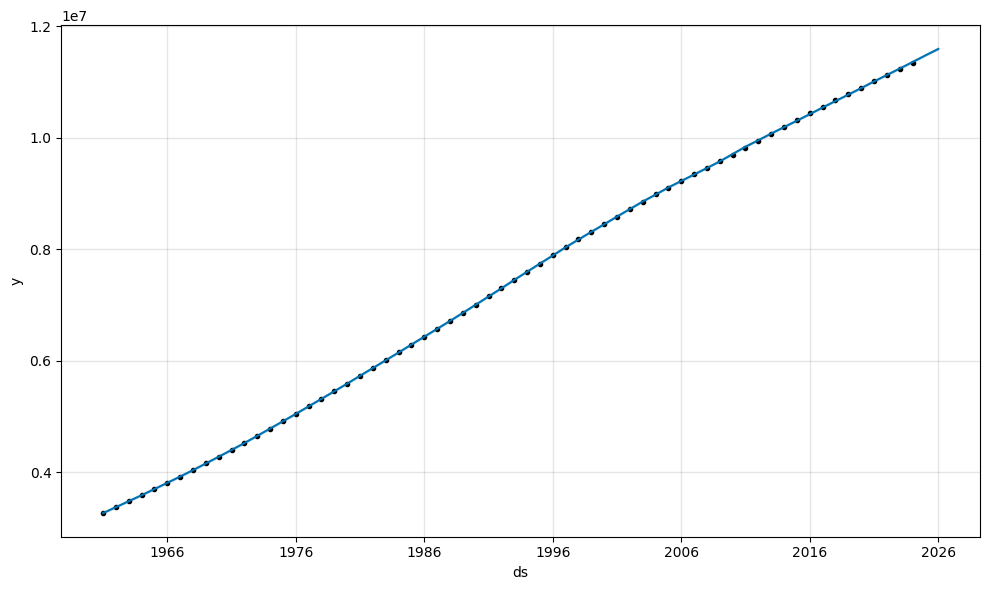

In [55]:
fig1 = m.plot(forecast)

In [51]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [52]:
plot_components_plotly(m, forecast)

In [53]:
predicciones = forecast[['ds', 'yhat']]
predicciones.columns = ['fecha', 'predicciones']
predicciones['year'] = predicciones['fecha'].dt.year
predicciones = predicciones[['year', 'predicciones']]

In [54]:
predicciones.to_csv('../../Datos/datos_predichos/df_poblacion_predicciones.csv')